# 파이토치로 구현하는 신경망

파이토치를 이용하여 가장 기본적인 신경망을 만들어봅니다.

## 프로젝트 2. 신경망 모델 구현하기

### 간단한 분류 모델 구현하기

In [1]:
import torch
import numpy
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plot
import torch.nn.functional as F

인공신경망을 구현하기 전 인공신경망의 학습과 평가를 위한 데이터셋을 만들어 줍니다.
밑의 코드에서 x_tra 와 y_tra 라고 정의된 실험데이터는 직접 인공신경망을 학습시키는데 쓰이는 데이터 입니다. 반대로 x_tes 와 y_tes 라고 정의된 데이터는 직접 신경망을 학습시키는데는 쓰이지 않지만 학습이 끝난 신경망의 성능을 평가하고 실험하는데 쓰일 데이터 셋입니다.

make_blobs() 함수를 이용하여 데이터를 2차원 벡터의 형태로 만들어 주었습니다.
학습데이터(Training Data Set)에는 80개, 실험데이터(Test Data Set)에는 20개의 2차원 벡터 형태의 데이터가 있는 것을 확인하실 수 있습니다.
데이터를 만든 후, 데이터에 해당하는 정답인 ‘레이블’ 을 달아줍니다. label_map 이라는 간단한 함수를 구현해 데이터가 [-1, -1] 혹은 [1, 1] 주위에 있으면 0 이라는 레이블을 달아 줬습니다. 반대로 [1, -1] 혹은 [-1, 1] 주위에 위치해 있으면 1 이라는 레이블을 달아 줬습니다.

In [2]:
def label_map(y_, from_, to_):
    y = numpy.copy(y_)
    for f in from_:
        y[y_ == f] = to_
    return y
  
n_dim = 2
x_tra, y_tra = make_blobs(n_samples=80, n_features=n_dim, centers=[[1,1],[-1,-1],[1,-1],[-1,1]], shuffle=True, cluster_std=0.3)
x_tes, y_tes = make_blobs(n_samples=20, n_features=n_dim, centers=[[1,1],[-1,-1],[1,-1],[-1,1]], shuffle=True, cluster_std=0.3)
y_tra = label_map(y_tra, [0, 1], 0)
y_tra = label_map(y_tra, [2, 3], 1)
y_tes = label_map(y_tes, [0, 1], 0)
y_tes = label_map(y_tes, [2, 3], 1)

데이터가 제대로 만들어 졌는지, 그리고 제대로 레이블링이 되었는지 확인하기 위해 matplotlib 을 이용해 데이터를 시각화 해 보겠습니다.

레이블이 0 인 학습 데이터는 점으로, 1인 데이터는 십자가로 표시했습니다.

<img src="./images/data_distribution.png" width="200">

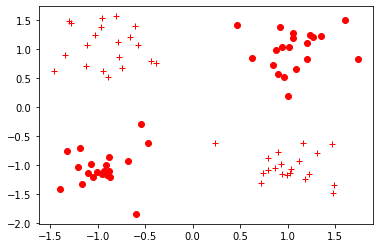

In [3]:
def vis_data(x,y = None, c = 'r'):
    if y is None:
        y = [None] * len(x)
    for x_, y_ in zip(x,y):
        if y_ is None:
            plot.plot(x_[0], x_[1], '*',markerfacecolor='none', markeredgecolor=c)
        else:
            plot.plot(x_[0], x_[1], c+'o' if y_ == 0 else c+'+')

plot.figure()
vis_data(x_tra, y_tra, c='r')
plot.show()

마지막으로 신경망을 구현 하기 전, 위에서 정의한 데이터들을 넘파이 리스트가 아닌 파이토치 텐서로 바꿔줍니다.

In [4]:
x_tra = torch.FloatTensor(x_tra)
x_tes = torch.FloatTensor(x_tes)
y_tra = torch.FloatTensor(y_tra)
y_tes = torch.FloatTensor(y_tes)

In [5]:
class Feed_forward_nn(torch.nn.Module):
        def __init__(self, input_size, hidden_size):
            super(Feed_forward_nn, self).__init__()
            self.input_size = input_size
            self.hidden_size  = hidden_size
            self.linear_1 = torch.nn.Linear(self.input_size, self.hidden_size)
            self.relu = torch.nn.ReLU()
            self.linear_2 = torch.nn.Linear(self.hidden_size, 1)
            self.sigmoid = torch.nn.Sigmoid()
        def forward(self, input_tensor):
            linear1 = self.linear_1(input_tensor)
            relu = self.relu(linear1)
            linear2 = self.linear_2(relu)
            output = self.sigmoid(linear2)
            return output

input_size 를 2로, hidden_size 를 5 로 설정한 신경망 객체를 만들었습니다. learning_rate 은 ‘얼마나 급하게 학습하는가’ 를 설정하는 값입니다. 값이 너무 크면 오차함수의 최소점을 찾지 못하고 지나치게 되고, 값이 너무 작으면 학습속도가 느려집니다.
러닝레이트를 설정했으면 그 다음으로는 오차함수를 만들어야 합니다. 물론 직접 오차함수를 코딩 할 수도 있지만 이는 매우 까다롭고 귀찮은 일입니다. 다행히도 파이토치는 여러 오차함수를 미리 구현해서 바로 사용 할 수 있도록 해놓았습니다. 이번에 우리는 파이토치가 제공해 주는 이진교차 엔트로피(Binary Cross Entropy) 라는 오차함수를 사용하겠습니다.

epochs는 학습데이터를 총 몇번 반복
동안 오차를 구하고 그 최소점으로 이동 할지 결정해줍니다. 
마지막 변수 optimizer 는 최적화 알고리즘입니다. 최적화 알고리즘 에는 여러 종류가 있고 상황에 따라 다른 알고리즘을 사용합니다. 이번 예제를 통해 처음으로 인공신경망을 구현하는 분들을 위해 그중에서도 가장 기본적인 알고리즘인 스토카스틱 경사 하강법(Stochastic Gradient Descent)을 사용하겠습니다.

In [6]:
model = Feed_forward_nn(2, 5)
learning_rate = 0.03
criterion = torch.nn.BCELoss()
epochs = 1000
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

In [7]:
model.eval()
test_loss_before =  criterion(model(x_tes).squeeze(), y_tes)
print('Before Training, test loss is ', test_loss_before.item())

Before Training, test loss is  0.684867262840271


오차값이 0.73 이 나왔습니다. 이정도의 오차를 가진 모델은 사실상 분류하는 능력이 없다고 봐도 무방합니다.
자, 이제 드디어 인공신경망을 학습시켜 퍼포먼스를 향상시켜 보겠습니다.

In [8]:
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    train_output = model(x_tra)
    train_loss = criterion(train_output.squeeze(), y_tra)
    if epoch % 100 == 0:
        print('Train loss at ', epoch, 'is ', train_loss.item())
    train_loss.backward()
    optimizer.step()

Train loss at  0 is  0.6783751249313354
Train loss at  100 is  0.59564608335495
Train loss at  200 is  0.5216876268386841
Train loss at  300 is  0.4660666882991791
Train loss at  400 is  0.41986387968063354
Train loss at  500 is  0.36197298765182495
Train loss at  600 is  0.29598739743232727
Train loss at  700 is  0.24807362258434296
Train loss at  800 is  0.20990189909934998
Train loss at  900 is  0.17989470064640045


In [9]:
model.eval()
test_loss = criterion(model(x_tes).squeeze(), y_tes) 
print('After Training, test loss is ', test_loss.item())

After Training, test loss is  0.15013645589351654


학습을 하기 전과 비교했을때 현저하게 줄어든 오차값을 확인 하실 수 있습니다.
지금까지 인공신경망을 구현하고 학습시켜 보았습니다.
이제 학습된 모델을 .pt 파일로 저장해 보겠습니다.

In [10]:
torch.save(model.state_dict(), './model.pt')

`save()` 를 실행하고 나면 학습된 신경망의 가중치를 내포하는 model.pt 라는 파일이 생성됩니다. 아래 코드처럼 새로운 신경망 객체에 model.pt 속의 가중치값을 입력시키는 것 또한 가능합니다.

In [11]:
new_model = Feed_forward_nn(2, 5)
new_model.load_state_dict(torch.load('./model.pt'))
new_model.eval()
print(new_model(torch.FloatTensor([-1,1])).item() )

0.970610499382019


벡터 [-1,1]을 학습하고 저장된 모델에 입력시켰을 때 레이블이 1일 확률은 90% 이상이 나옵니다.
우리의 첫번째 신경망 모델은 이제 꽤 믿을만한 분류 작업이 가능하게 된 것입니다.

```python
벡터 [-1,1]이 레이블 1 을 가질 확률은  0.9745796918869019
```